In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import botorch
from pak.choose import *
from pak.function import *
from pak.GPmodel import fit_gp_model
from pak.plotfunc import visualize_2d_contour
from skopt.sampler import Lhs
import warnings
warnings.filterwarnings("ignore")
torch.set_default_tensor_type(torch.DoubleTensor)

funcname = 'Fn18M'
func = choose(funcname)

#### 定义函数，搜索空间和预算个数

In [2]:
fn = func[0]
f = func[1]
search_space = [[-5.0, 5.0], [-5.0, 5.0]] 
bounds = torch.tensor([[-5.0, -5.0], [5.0, 5.0]])
budgets = 300

#### 初始化(拉丁超立方采样)

In [3]:
lhs = Lhs()
samples = lhs.generate(search_space, n_samples=round(0.1*budgets))
train_x = torch.tensor(samples)
train_y = []
for x in train_x:
    train_y.append(fn(x.numpy()))
train_y = torch.tensor(train_y)

total_x = torch.tensor([])

In [4]:
for i in tqdm(range(budgets-len(samples))):

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ExpectedImprovement(
        model, best_f=model(train_x).mean.min(), maximize = False
    )

    total = botorch.acquisition.analytic.UpperConfidenceBound(
        model, beta = 0.0, maximize = False
    )

    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=bounds,
        q=1,
        num_restarts=40,
        raw_samples=100,
    )

    next_x_total, acq_val_total = botorch.optim.optimize_acqf(
        total,
        bounds=bounds,
        q=1,
        num_restarts=40,
        raw_samples=100,
    )

    next_y = torch.tensor(fn(next_x.numpy()))

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

    total_x = torch.cat([total_x, next_x_total])

  0%|          | 0/270 [00:00<?, ?it/s]

In [5]:
x1_range = torch.linspace(-5, 5, 1000)
x2_range = torch.linspace(-5, 5, 1000)
X1, X2 = torch.meshgrid(x1_range, x2_range, indexing="ij")
xs = torch.vstack((X1.flatten(), X2.flatten())).transpose(-1, -2)
suggest_x = train_x[model(train_x).mean.argmin().numpy()].numpy()
suggest_y = f(suggest_x)
suggest = [suggest_x,suggest_y]

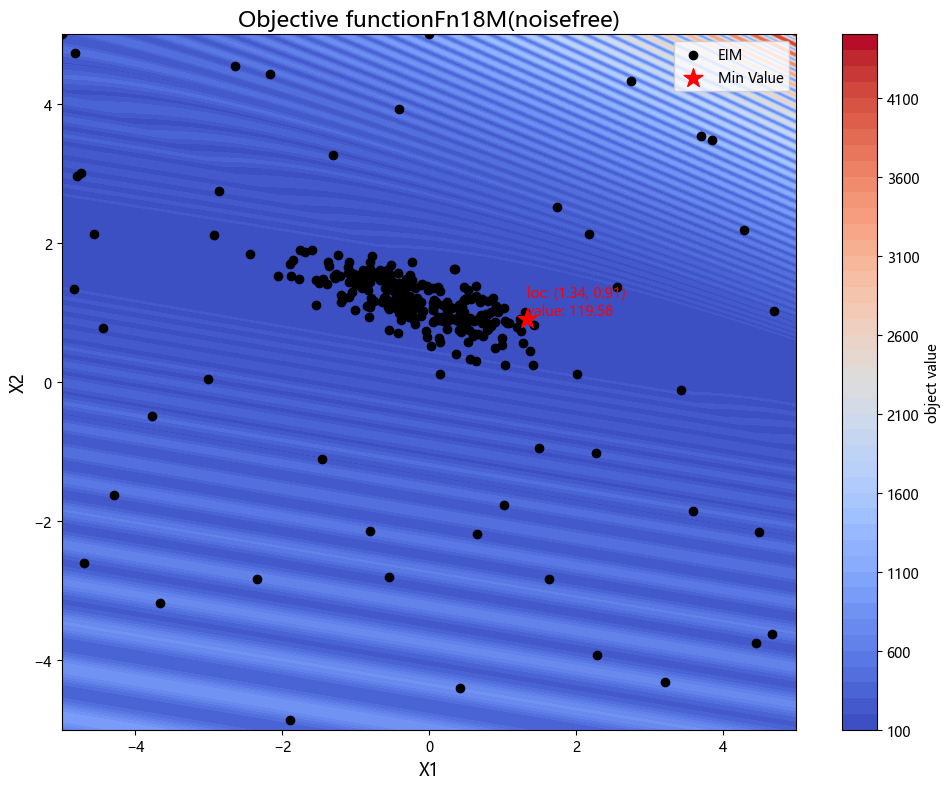

In [6]:
data = f(xs.numpy())
visualize_2d_contour(name='Objective function '+funcname+'(noisefree)',x1_range=x1_range,x2_range=x2_range, data=data, train_x=train_x,labelx="EIM")

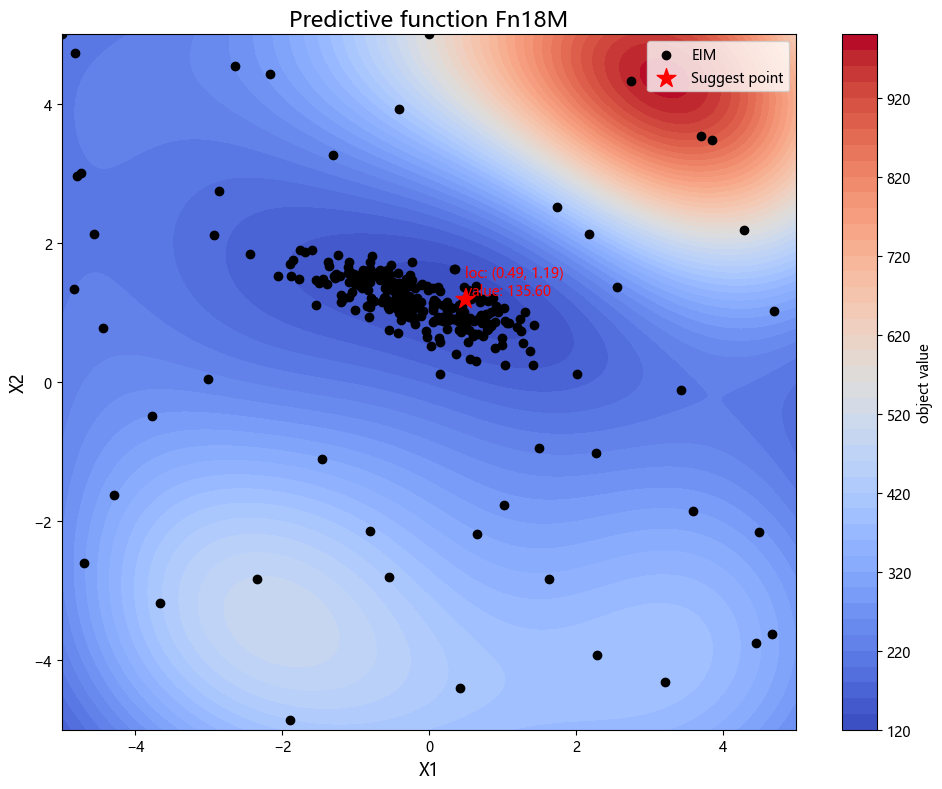

In [7]:
data = model(xs).mean.detach().numpy()
visualize_2d_contour(name='Predictive function '+funcname,x1_range=x1_range,x2_range=x2_range,data=data,train_x=train_x,suggest=suggest,labelx="EIM")

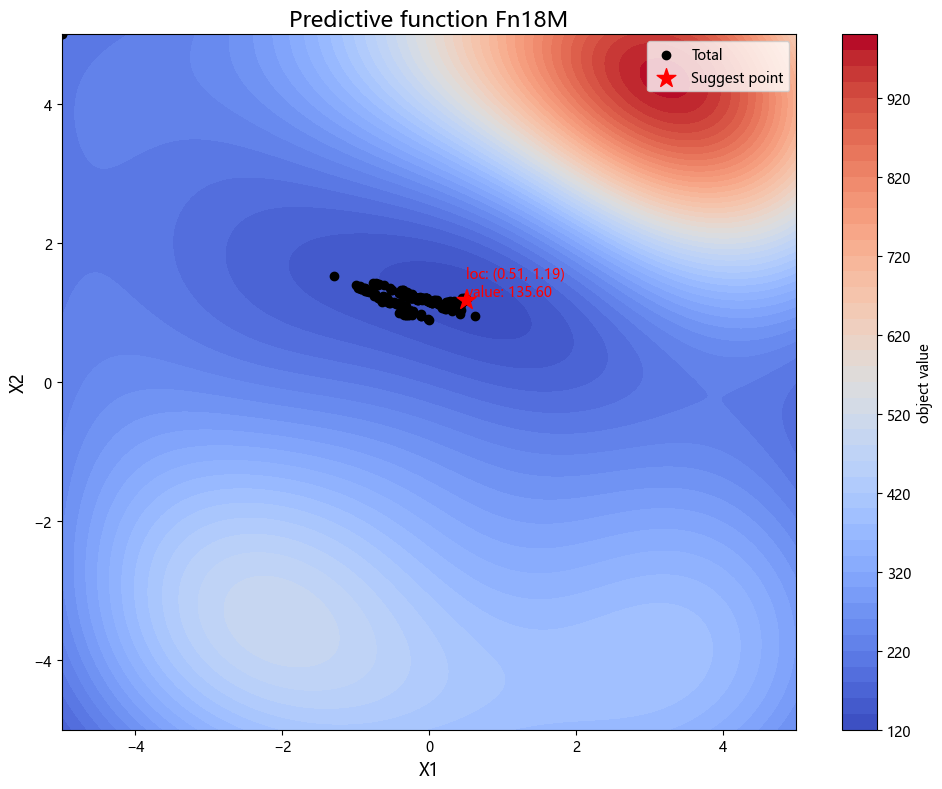

In [8]:
suggest_x_total = total_x[-1].numpy()
suggest_y_total = f(suggest_x)
suggest = [suggest_x_total,suggest_y_total]
data = model(xs).mean.detach().numpy()
visualize_2d_contour(name='Predictive function '+funcname,x1_range=x1_range,x2_range=x2_range,data=data,train_x=total_x,suggest=suggest,labelx="Total")